# Reaching Impressions Goal for Facebook Campaigns

## Introduction

In today’s fast-paced world of digital advertising, platforms like Meta have become dominant players, generating over $150 billion in revenue in 2024 [1]. For marketing agencies, particularly those serving mid-sized clients, navigating Meta’s unique advertising ecosystem presents a significant challenge.

---

## Problem Statement

Unlike traditional advertising channels, where metrics such as impressions can be directly controlled, Meta’s platform relies on budget-driven performance. This creates a complex dynamic where achieving specific goals—such as impressions or conversions—within a set budget requires constant monitoring and adjustments. These manual processes are not only time-intensive but also highly prone to errors.

`pi_optimal` addresses these challenges by utilizing reinforcement learning (RL) to automate and optimize advertising campaign management. By harnessing the power of RL, `pi_optimal` enables data science teams—regardless of their expertise in advanced RL — to efficiently control campaigns that consistently achieve their goals.

Our objective is to develop a model that is able to set the optimal setting for the Facebook campaign in order to reach the desired number of impressions. Additionally we want to understand how the model came to those decsion and see if we could trust the model to make the right decision.


---

## Dataset

The dataset was provided to us by a mid-sized marketing agency from germany. It includes over 2574 facebook campaigns which had been run between 2019 and 2022. The information for the campaigns had been aggregated on a daily basis. The dataset includes the following columns:


### Dataset Features

- `campaign_id`: Unique identifier for each campaign
- `date`: Date of the data point
- `day_of_week`: Day of the week
- `impression_goal`: The target number of impressions for the campaign by the end of the runtime
- `daily_impressions`: The number of impressions generated by the campaign on that day
- `total_impressions`: The total number of impressions generated until that day
- `target_daily_impressions`: The target number of impressions for that day
- `target_total_impressions`: The target number of impressions until that day
- `missing_impressions`: The difference between the target and actual impressions for that day
- `total_days`: The total number of days the campaign has been running
- `remaining_days`: The number of days remaining for the campaign to run
- `set_cpm`: The cost per thousand impressions set for the campaign
- `feed_facebook_status`: Indicated if the campaign was run on the Facebook feed at that day
- `instant_article_facebook_status`: Indicated if the campaign was run on the Instant Article feed at that day
- `facebook_stories_facebook_status`: Indicated if the campaign was run on the Facebook Stories feed at that day
- `marketplace_facebook_status`: Indicated if the campaign was run on the Marketplace feed at that day
- `right_hand_column_facebook_status`: Indicated if the campaign was run on the Right Hand Column feed at that day

In [1]:
import pandas as pd

df_historical_fb_camapigns = pd.read_csv('data/fb_history.csv', parse_dates=['date'])
df_historical_fb_camapigns.sort_values(['campaign_id', 'date'], inplace=True)
df_historical_fb_camapigns.head()

,campaign_id,date,day_of_week,impression_goal,daily_impressions,total_impressions,target_daily_impressions,target_total_impressions,missing_impressions,total_days,remaining_days,set_cpm,feed_facebook_status,instant_article_facebook_status,facebook_stories_facebook_status,marketplace_facebook_status,right_hand_column_facebook_status
0,0,2022-05-30,Monday,21000,1244.0,1244.0,1400.0,1400.0,156.0,15.0,13.0,3.0,Active,Active,Active,Active,Inactive
1,0,2022-06-01,Wednesday,21000,915.0,2159.0,1400.0,2800.0,641.0,15.0,11.0,3.0,Active,Active,Active,Active,Inactive
2,0,2022-06-08,Wednesday,21000,5225.0,7384.0,1400.0,4200.0,-3184.0,15.0,4.0,3.0,Active,Active,Active,Active,Active
3,0,2022-06-09,Thursday,21000,4402.0,11786.0,1400.0,5600.0,-6186.0,15.0,3.0,3.0,Active,Active,Active,Active,Active
4,0,2022-06-10,Friday,21000,3202.0,14988.0,1400.0,7000.0,-7988.0,15.0,2.0,2.0,Active,Active,Active,Active,Active


In [2]:
# Uncomment the following lines for faster training and inference if you have sklearnex installed and are using an Intel CPU

import numpy as np
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
# Add the root path to the sys path to load pi_optimal from the parent directory
import sys
sys.path.append("../..")

---

## Defining the Reward Function

In order to teach the model to make good decsison, we have to define what a good decsion is. In RL we use a so called reward function for that. This is a function which takes the currect state of a campigan (e.g. the number of impressions, settings, ...) and returns a value which indicates how good the current state is. The RL model then tries to maximize this value. Here we define a very simple function that tries to minimize the difference between the target and actual impressions. But this function could be arbitray complex and could include any information we have about the campaign, like budget, target audience, ...

### Implementation

In [4]:
# Function to calculate reward
def calculate_reward(row, epsilon=1e-8):

    # Reward is just the negative of the absolute missing impressions
    # so we try to minimize the missing the over and under delivery
    reward = -abs(row.daily_impressions - row.missing_impressions)
    reward = -abs(row.missing_impressions)
    
    return reward

### Apply the reward function to the dataset

In [5]:
# Apply the reward calculation
df_historical_fb_camapigns['reward'] = df_historical_fb_camapigns.apply(calculate_reward, axis=1)
df_historical_fb_camapigns.head()

,campaign_id,date,day_of_week,impression_goal,daily_impressions,total_impressions,target_daily_impressions,target_total_impressions,missing_impressions,total_days,remaining_days,set_cpm,feed_facebook_status,instant_article_facebook_status,facebook_stories_facebook_status,marketplace_facebook_status,right_hand_column_facebook_status,reward
0,0,2022-05-30,Monday,21000,1244.0,1244.0,1400.0,1400.0,156.0,15.0,13.0,3.0,Active,Active,Active,Active,Inactive,-156.0
1,0,2022-06-01,Wednesday,21000,915.0,2159.0,1400.0,2800.0,641.0,15.0,11.0,3.0,Active,Active,Active,Active,Inactive,-641.0
2,0,2022-06-08,Wednesday,21000,5225.0,7384.0,1400.0,4200.0,-3184.0,15.0,4.0,3.0,Active,Active,Active,Active,Active,-3184.0
3,0,2022-06-09,Thursday,21000,4402.0,11786.0,1400.0,5600.0,-6186.0,15.0,3.0,3.0,Active,Active,Active,Active,Active,-6186.0
4,0,2022-06-10,Friday,21000,3202.0,14988.0,1400.0,7000.0,-7988.0,15.0,2.0,2.0,Active,Active,Active,Active,Active,-7988.0


---

## Dataset Preparation

To train a `pi_optimal` RL agent, we must first load and preprocess the ad dataset. The `pi_optimal` package provides a custom dataset class that streamlines the preprocessing pipeline. Below are the key parameters that need to be defined during this process:

- **Unit Index**:  
   This parameter, `unit_index`, identifies distinct units in the dataset. In our case, each unit corresponds to unique adset (`campaign_id` column).

- **Time Column**:  
   The time column (`timestep_column`) establishes the temporal sequence of data points, enabling the model to learn from historical trends. For instance, the RL agent can consider the previous 24 hours of data (set by the `lookback_timesteps` parameter) to make informed decisions. In our case we would use the datetime column `date`.

- **Reward Column**:  
   The `reward_column` specifies the target that the agent seeks to optimize. Here, we previously calculated and added the `reward` column to the dataset, which reflects just the distance between the current total impressions and the expected current impression given the progression of the campaign.

- **State Columns**:  
   The state columns capture the system's current status, it includes all variables that influence campaigns delivery performance. Relevant examples include:  
   - `daily_impressions`  
   - `day_of_week`  
   - `impression_goal`  
   - ...

   These features help the agent assess the current environment and predict outcomes effectively.

- **Action Columns**:  
   The action columns represent controllable variables, such as the CPM set or the placements that are activated.

By carefully defining these parameters, we ensure that the RL agent can interpret the dataset's structure, learn from past patterns, and make optimized decisions to optimize adset delivery.

## Dataset Preparation

In [6]:
state_cols = [
    'daily_impressions',
    'day_of_week',
    'impression_goal',
    'total_impressions',
    'target_daily_impressions',
    'missing_impressions',
]

action_cols = [
    'set_cpm',
    'feed_facebook_status',
    'instant_article_facebook_status',
    'facebook_stories_facebook_status',
    'marketplace_facebook_status',
    'right_hand_column_facebook_status',
]

reward_col = 'reward'

timestamp_col = 'date'

unit_col = 'campaign_id'

### Configuration

Beides the columns mentioned above, we could also adjust the number of lookback timesteps for predicting how the campaign will evolve in the future. In our case we consider the last 7 days of data to make a decision. Now the dataset will be initialized, the features will be preprocessed and the dataset will be prepared for training.

In [7]:
import pi_optimal as po

LOOKBACK_TIMESTEPS = 7
historical_dataset = po.datasets.timeseries_dataset.TimeseriesDataset(df=df_historical_fb_camapigns,
                                                                      state_columns=state_cols,
                                                                      action_columns=action_cols,
                                                                      reward_column=reward_col,
                                                                      timestep_column=timestamp_col,
                                                                      unit_index=unit_col,
                                                                      lookback_timesteps=LOOKBACK_TIMESTEPS)

## Agent Initialization and Training

As we have now a read to train dataset, we can initialize the agent and start the training. But as we want to restrict our agent to not set impossible aor expensive decision we add constrains on our actions, namely the CPM setting as well as the placements.

In [8]:
from pi_optimal.agents.agent import Agent
import numpy as np

agent = Agent(dataset=historical_dataset,
                 type="mpc-continuous",
                 constraints= {
                        'min': np.array([0.1,  "Active", "Active", "Active", "Active", "Active"]),                       # Min values for: CPM, Feed, Instant Article, Stories, Marketplace, Right Hand Column
                        'max': np.array([9.0, "Inactive", "Inactive", "Inactive", "Inactive", "Inactive"])               # Max values for: CPM, Feed, Instant Article, Stories, Marketplace, Right Hand Column
                        },
                )


agent.train()

100%|██████████| 7/7 [00:24<00:00,  3.47s/it]


## Evaluation and Action Prediction

After our RL aggent was trained successfully we now have the chance to load a spesific campaign and see how the agent would set the campaign settings in order to reach the desired number of impressions.



### Load Current Data

We select here two campaigns which were not part of the training set. One campiagn is underperforming, so the agent should increase the CPM. The other campaign is overperforming, so the agent should decrease the CPM. We will start with the underperforming campaign.

In [9]:
# Load the current adset control data

# df_current_adset_control = pd.read_csv('data/fb_current_over_deliver.csv', parse_dates=['date'])
df_current_adset_control = pd.read_csv('data/fb_current_under_deliver.csv', parse_dates=['date'])

# Apply the reward calculation
df_current_adset_control["reward"] = df_current_adset_control.apply(calculate_reward, axis=1)

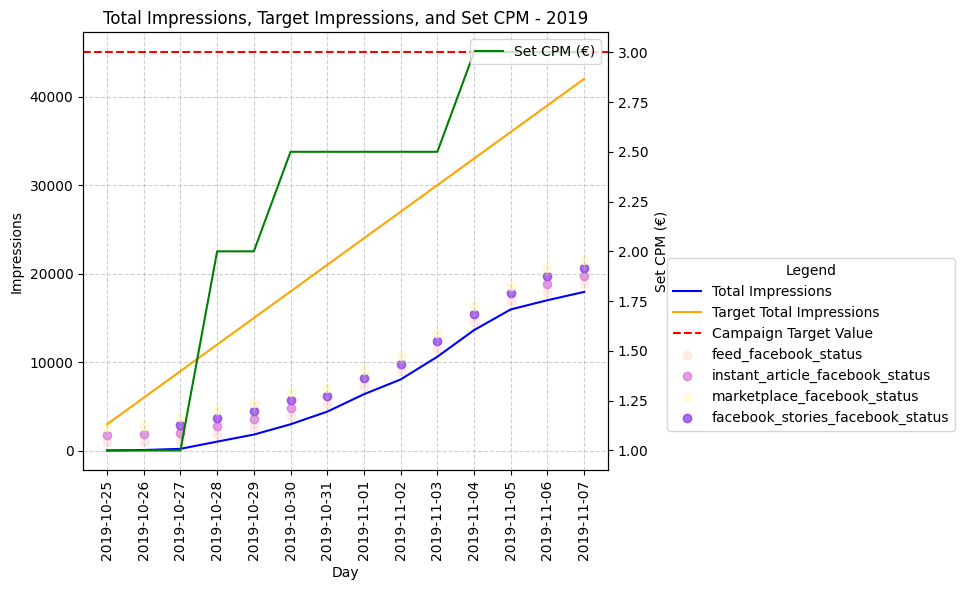

In [10]:
from util_plot import plot_campaign

plot_campaign(df_current_adset_control.copy())

### Create Current Dataset

For our dataset we would like what happen if we would let the agent make decisions for the last 7 days. After we cutout the last 7 days of the campaign we can now create a dataset for the agent to predict the optimal actions.

In [11]:
df_current_adset_control = df_current_adset_control.iloc[:-7]

current_dataset = po.datasets.timeseries_dataset.TimeseriesDataset(df=df_current_adset_control,
                                                                    dataset_config=historical_dataset.dataset_config,
                                                                    lookback_timesteps=LOOKBACK_TIMESTEPS,
                                                                    train_processors=False,
                                                                    is_inference=True)

### Predict Optimal Actions

In [12]:
best_actions = agent.predict(current_dataset)

100%|██████████| 4/4 [00:00<00:00, 19.86it/s]


Iteration: 1, Top-100 Cost: 0.1334 (Cost: 0.4237, Uncertainty: 0.5763)


100%|██████████| 4/4 [00:00<00:00, 20.22it/s]


Iteration: 2, Top-100 Cost: 0.1305 (Cost: 0.5239, Uncertainty: 0.4761)


100%|██████████| 4/4 [00:00<00:00, 20.73it/s]


Iteration: 3, Top-100 Cost: 0.1296 (Cost: 0.5279, Uncertainty: 0.4721)


100%|██████████| 4/4 [00:00<00:00, 20.58it/s]


Iteration: 4, Top-100 Cost: 0.1001 (Cost: 0.509, Uncertainty: 0.491)


100%|██████████| 4/4 [00:00<00:00, 20.80it/s]


Iteration: 5, Top-100 Cost: 0.1016 (Cost: 0.4921, Uncertainty: 0.5079)


100%|██████████| 4/4 [00:00<00:00, 20.92it/s]


Iteration: 6, Top-100 Cost: 0.1012 (Cost: 0.5299, Uncertainty: 0.4701)


100%|██████████| 4/4 [00:00<00:00, 20.24it/s]


Iteration: 7, Top-100 Cost: 0.0944 (Cost: 0.56, Uncertainty: 0.44)


100%|██████████| 4/4 [00:00<00:00, 20.53it/s]


Iteration: 8, Top-100 Cost: 0.117 (Cost: 0.6401, Uncertainty: 0.3599)


100%|██████████| 4/4 [00:00<00:00, 20.74it/s]


Iteration: 9, Top-100 Cost: 0.1047 (Cost: 0.5071, Uncertainty: 0.4929)


100%|██████████| 4/4 [00:00<00:00, 20.80it/s]


Iteration: 10, Top-100 Cost: 0.0921 (Cost: 0.5152, Uncertainty: 0.4848)


---

## Interpreting the Results

The agent provides a sequence of optimal actions for the time horizon. Here we print them:

In [13]:
for i in range(len(best_actions)):
    print(f"Timestep {i}:")
    print("Maximum CPM:", best_actions[i][0])
    print("Feed Facebook Status:", best_actions[i][1])
    print("Instant Article Facebook Status:", best_actions[i][2])
    print("Facebook Stories Facebook Status:", best_actions[i][3])
    print("Marketplace Facebook Status:", best_actions[i][4])
    print("Right Hand Column Facebook Status:", best_actions[i][5])
    print()
    print("--------------------")
    print()

Timestep 0:
Maximum CPM: 0.1257159594105164
Feed Facebook Status: Active
Instant Article Facebook Status: Active
Facebook Stories Facebook Status: Active
Marketplace Facebook Status: Active
Right Hand Column Facebook Status: Active

--------------------

Timestep 1:
Maximum CPM: 5.5931217441937555
Feed Facebook Status: Inactive
Instant Article Facebook Status: Inactive
Facebook Stories Facebook Status: Inactive
Marketplace Facebook Status: Inactive
Right Hand Column Facebook Status: Active

--------------------

Timestep 2:
Maximum CPM: 0.8511274220003242
Feed Facebook Status: Inactive
Instant Article Facebook Status: Active
Facebook Stories Facebook Status: Active
Marketplace Facebook Status: Active
Right Hand Column Facebook Status: Active

--------------------

Timestep 3:
Maximum CPM: 7.050472358295837
Feed Facebook Status: Inactive
Instant Article Facebook Status: Inactive
Facebook Stories Facebook Status: Active
Marketplace Facebook Status: Inactive
Right Hand Column Facebook Sta

--- 

## Visualization of Scenarios

`pi_optimal` include the ability to visualize the results of the agent. Here we visualize the results of the agent for the underperforming campaign. We can see that the agent increased the CPM in order to reach the desired number of impressions. We can playaround with the parameter to see how the agent would react to different settings.

In [17]:
from pi_optimal.utils.trajectory_visualizer import TrajectoryVisualizer

trajectory_visualizer = TrajectoryVisualizer(agent, current_dataset, best_actions=best_actions)
trajectory_visualizer.display()

100%|██████████| 4/4 [00:00<00:00, 30.29it/s]


---

## Conclusion

This notebook demonstrates how `pi_optimal` could be use to automate the control of facebook campaigns to reach a spesific impressions goal. Additional we have seen how we could use pi_optimal to run hypothestical scenarios. This could be used to understand how the agent would react to different settings or to understand how the agent would react to different scenarios.


### Key Highlights

- **Dataset Preparation**: 
   The dataset was prepared for training by defining the key parameters required for the RL agent. There is no need to manually preprocess the data, as the `pi_optimal` package streamlines this process.
- **Agent Training**: 
   The RL agent was trained on the dataset, learning to optimize the campaign settings to reach the desired impressions goal.
- **Action Prediction**:
    The agent predicted the optimal actions for two campaigns, one underperforming and one overperforming, to reach the desired impressions goal.
- **Simulation Visualization**:
    The results of the agent were visualized to understand how the agent would react to different scenarios.

---

## Next Steps

1. **Enhance Reward Function**: Use custom reward functions that incorporate additional features, such as budget constraints, audience targeting, or creative performance. By designing more complex reward functions, you can guide the agent to make decisions that align with broader campaign objectives.

2. **Hyperparameter Tuning**: Optimize the hyperparameters of the RL agent to improve its performance. By conducting a hyperparameter search, you can identify the optimal configuration that maximizes the agent's ability to reach the impressions goal.

3. **Real-Time Decision-Making**: Implement the agent in a real-time decision-making system to automate the optimization of Facebook campaigns. By integrating the agent into your existing ad management platform, you can leverage its capabilities to enhance campaign performance and efficiency.

# References

[1] https://investor.atmeta.com/home/